In [10]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [11]:
torch.manual_seed(430)

#### AutoEncoder Model

In [12]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(AutoEncoder, self).__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size

        sub_hidden_sizes = [256, 64]
        
        self.encoder = nn.Sequential(
            nn.Flatten(start_dim=1, end_dim=3),
            nn.Linear(input_size, sub_hidden_sizes[0], bias=True),
            nn.Sigmoid(),
            nn.Linear(sub_hidden_sizes[0], sub_hidden_sizes[1], bias=True),
            nn.Sigmoid(),
            nn.Linear(sub_hidden_sizes[1], hidden_size, bias=True),
        )

        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, sub_hidden_sizes[1], bias=True),
            nn.Sigmoid(),
            nn.Linear(sub_hidden_sizes[1], sub_hidden_sizes[0], bias=True),
            nn.Sigmoid(),
            nn.Linear(sub_hidden_sizes[0], input_size, bias=True),
            nn.Sigmoid(),
            nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))
        )

    def forward(self, input):
        ''' 
        input: tensor of size (batch_size, input_size)
        output: tensor of size (batch_size, input_size)
        '''
        encoded = self.encoder(input)
        assert encoded.shape[0] == input.shape[0]
        assert encoded.shape[1] == self.hidden_size

        decoded = self.decoder(encoded)
        return decoded
    
    def get_embedding(self, input):
        '''
        input: tensor of size (batch_size, input_size)
        output: tensor of size (batch_size, hidden_size)
        '''
        with torch.no_grad():
            return self.encoder(input)

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=8)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=testset.data.shape[0], shuffle=True, num_workers=8)

In [14]:
train_data = trainset.data
train_labels = trainset.targets
test_data = testset.data
test_labels = testset.targets
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])
torch.Size([10000, 28, 28])
torch.Size([10000])


In [15]:
n_epochs = 10
model = AutoEncoder(input_size=784, hidden_size=32)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

training_losses = []
test_losses = []

for epoch in range(n_epochs):
        training_loss = 0
        model.train()
        for step, batch in enumerate(tqdm(trainloader, desc=f"Epoch: {epoch+1}/{n_epochs}", leave=True, unit="batch")):
                input = batch[0]
                # input /= input.max()
                assert torch.equal(torch.tensor(input.shape[1:]), torch.tensor([1, 28, 28]))
                optimizer.zero_grad()
                output = model(input)
                assert torch.equal(torch.tensor(output.shape), torch.tensor([input.shape[0], 1, 28, 28]))
                loss = criterion(output, input)
                loss.backward()
                optimizer.step()
                training_loss += loss.item()

        model.eval()
        with torch.no_grad():
                testing_loss = 0
                for batch in testloader:
                        # input /= input.max()
                        assert torch.equal(torch.tensor(input.shape[1:]), torch.tensor([1, 28, 28]))
                        output = model(input)
                        assert torch.equal(torch.tensor(output.shape), torch.tensor([input.shape[0], 1, 28, 28]))
                        loss = criterion(output, input)
                        testing_loss += loss.item()

        training_losses.append(training_loss)
        test_losses.append(testing_loss)
                
        print(f'=====> Average Training, Testing Loss at epoch:{epoch+1} = {training_loss}, {testing_loss}\n')

Epoch: 1/10: 100%|██████████| 938/938 [00:05<00:00, 183.86batch/s]


=====> Average Training, Testing Loss at epoch:1 = 190.9247702807188, 0.16066333651542664



Epoch: 2/10: 100%|██████████| 938/938 [00:04<00:00, 196.45batch/s]


=====> Average Training, Testing Loss at epoch:2 = 144.52026864886284, 0.13603511452674866



Epoch: 3/10: 100%|██████████| 938/938 [00:04<00:00, 190.94batch/s]


=====> Average Training, Testing Loss at epoch:3 = 125.87746547162533, 0.12400875985622406



Epoch: 4/10: 100%|██████████| 938/938 [00:04<00:00, 188.24batch/s]


=====> Average Training, Testing Loss at epoch:4 = 114.53174144774675, 0.11581431329250336



Epoch: 5/10: 100%|██████████| 938/938 [00:04<00:00, 196.39batch/s]


=====> Average Training, Testing Loss at epoch:5 = 106.49778746068478, 0.10219473391771317



Epoch: 6/10: 100%|██████████| 938/938 [00:04<00:00, 197.34batch/s]


=====> Average Training, Testing Loss at epoch:6 = 100.19554439932108, 0.09074129164218903



Epoch: 7/10: 100%|██████████| 938/938 [00:04<00:00, 197.60batch/s]


=====> Average Training, Testing Loss at epoch:7 = 96.43923432379961, 0.10658343136310577



Epoch: 8/10: 100%|██████████| 938/938 [00:04<00:00, 203.71batch/s]


=====> Average Training, Testing Loss at epoch:8 = 93.89837011694908, 0.10517781227827072



Epoch: 9/10: 100%|██████████| 938/938 [00:04<00:00, 196.17batch/s]


=====> Average Training, Testing Loss at epoch:9 = 91.74746333807707, 0.08197686821222305



Epoch: 10/10: 100%|██████████| 938/938 [00:04<00:00, 196.56batch/s]


=====> Average Training, Testing Loss at epoch:10 = 90.07594125717878, 0.09505730867385864



tensor([8536, 9381, 9725, 9694,  686, 5453, 2260,  405,   68, 3074])


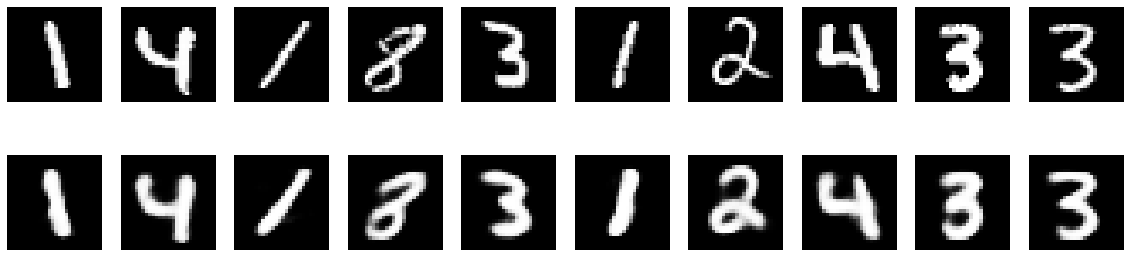

In [16]:
fig, ax = plt.subplots(2, 10, figsize=(20, 5))
indices = torch.randperm(test_data.shape[0])[0:10]
input = test_data[indices]
for i in range(10):
    ax[0][i].imshow(input[i], cmap='gray')
    ax[0][i].axis('off')

input = input.float().unsqueeze(1)
model.eval()
output = model(input)

for i in range(10):
    ax[1][i].imshow(output[i].squeeze(0).detach().numpy(), cmap='gray')
    ax[1][i].axis('off')
print(indices)

In [17]:
# plt.plot(range(len(training_losses)), [l/60000 for l in training_losses])
# plt.plot(range(len(test_losses)), [l/20000 for l in training_losses])
# plt.title("Average Loss vs iterations")
# plt.legend()
# plt.show()

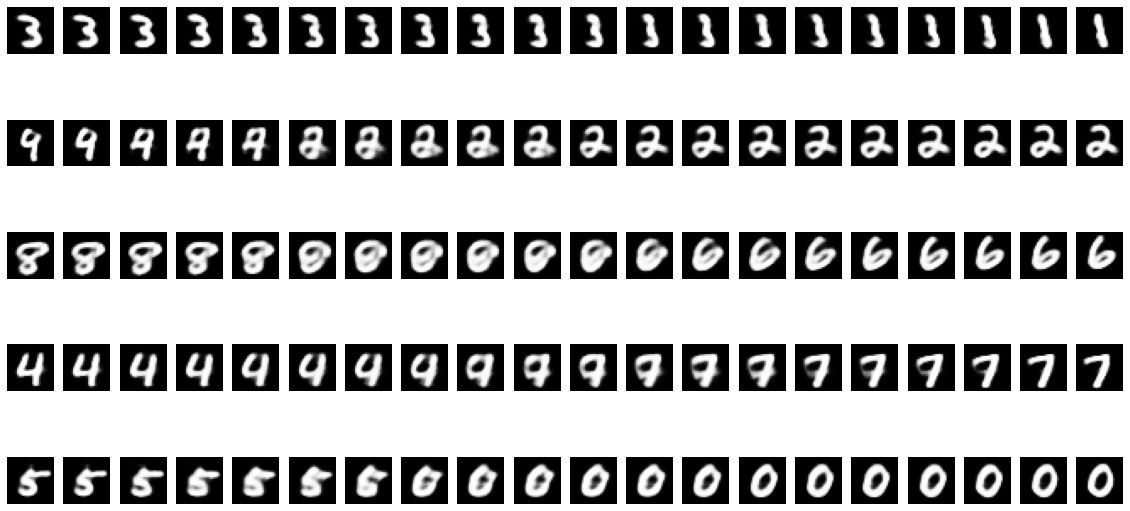

In [18]:
seq_length = 20
endpoints_list = [[8536, 686],[796, 3985],[9138, 9673],[4773, 7653],[6959, 6136]]

def get_images_between_two_points(num_images, endpoints):
    alpha = torch.linspace(0, 1, num_images)
    output = torch.zeros((num_images, 1, 28, 28))
    input_batch = torch.zeros((num_images, 1, 28, 28))
    for i in range(num_images):
        input_batch[i] = alpha[i]*test_data[endpoints[0]].float().unsqueeze(0) + (1-alpha[i])*test_data[endpoints[1]].float().unsqueeze(0)
    # print(input_batch.shape)
    model.eval()
    output = model(input_batch)
    assert torch.equal(torch.tensor(output.shape), torch.tensor([num_images, 1, 28, 28]))
    return output

fig, ax = plt.subplots(5, seq_length, figsize=(20, 10))
for j in range(5):
    output = get_images_between_two_points(seq_length, endpoints = endpoints_list[j])
    for i in range(seq_length):
        ax[j][i].imshow(output[i].squeeze(0).detach().numpy(), cmap='gray')
        ax[j][i].axis('off')
    